In [2]:
from mhcflurry.dataset import Dataset

Couldn't import dot_parser, loading of dot files will not be possible.


Using Theano backend.


In [3]:
data = Dataset.from_csv("bdata.2009.mhci.public.1.txt")

In [4]:
data.allele_counts_dictionary()

{'ELA-A1': 14,
 'Gogo-B0101': 15,
 'H-2-DB': 3216,
 'H-2-DD': 315,
 'H-2-KB': 3407,
 'H-2-KD': 452,
 'H-2-KK': 371,
 'H-2-LD': 301,
 'HLA-A0101': 3725,
 'HLA-A0201': 9565,
 'HLA-A0202': 3919,
 'HLA-A0203': 5542,
 'HLA-A0205': 56,
 'HLA-A0206': 4827,
 'HLA-A0207': 68,
 'HLA-A0210': 18,
 'HLA-A0211': 1038,
 'HLA-A0212': 1143,
 'HLA-A0216': 894,
 'HLA-A0219': 1203,
 'HLA-A0250': 132,
 'HLA-A0301': 6141,
 'HLA-A0302': 10,
 'HLA-A11': 74,
 'HLA-A1101': 5399,
 'HLA-A2': 44,
 'HLA-A2301': 2021,
 'HLA-A2402': 2533,
 'HLA-A2403': 1165,
 'HLA-A2501': 519,
 'HLA-A26': 4,
 'HLA-A2601': 2894,
 'HLA-A2602': 202,
 'HLA-A2603': 205,
 'HLA-A2902': 2397,
 'HLA-A3001': 2040,
 'HLA-A3002': 1430,
 'HLA-A3101': 4796,
 'HLA-A3201': 640,
 'HLA-A3301': 3040,
 'HLA-A6601': 4,
 'HLA-A6801': 3184,
 'HLA-A6802': 4768,
 'HLA-A6901': 2079,
 'HLA-A8001': 782,
 'HLA-B0702': 3412,
 'HLA-B0801': 2267,
 'HLA-B0802': 487,
 'HLA-B0803': 217,
 'HLA-B1402': 3,
 'HLA-B1501': 3213,
 'HLA-B1502': 164,
 'HLA-B1503': 429,
 'HLA-B

In [5]:
data.cross_validation_iterator??

In [6]:
from mhcflurry.class1_binding_predictor import Class1BindingPredictor

In [7]:
from sklearn.metrics import roc_auc_score, f1_score
from collections import OrderedDict

In [8]:
n_repeats = 3
n_folds = 3
min_observations_per_peptide = 5
min_observations_per_allele = 5
imputation_algorithm = "none"

n_training_epochs = 250
batch_size = 32 
dropout = 0.25
embedding_dim = 32


In [ ]:
columns = OrderedDict([
    ("allele", []),
    ("n_random_negative_samples", []),
    ("batch_normalization", []),
    ("dropout", []),
    ("repeat", []),
    ("auc", []),
    ("f1", []),
])

for allele in ["Patr-B0101"]:
    print("\n========> %s" % allele)
    for repeat in range(n_repeats):
        for i, (train_data, test_data) in enumerate(
                data.cross_validation_iterator(
                    test_allele=allele,
                    n_folds=n_folds,
                    stratify_fn=lambda x: x.affinity <= 500)): 
            
            train_allele = train_data.get_allele(allele)
            print("\n=== Allele %s, repeat %d/%d, CV fold %d/%d (n_train=%d, n_train_pos=%d, n_test=%d, n_test_pos=%d)" % (
                    allele,
                    repeat + 1, 
                    n_repeats,
                    i + 1,
                    n_folds,
                    len(train_allele),
                    np.sum(train_allele.affinities <= 500),
                    len(test_data),
                    np.sum(test_data.affinities <= 500)))
            imputed_data = train_data.impute_missing_values(
                            imputation_algorithm,
                            min_observations_per_peptide=min_observations_per_peptide,
                            min_observations_per_allele=min_observations_per_allele)
            if allele in imputed_data.unique_alleles():
                imputed_allele = imputed_data.get_allele(allele)
            else:
                imputed_allele = None
            for n_random_negative_samples in [0, 10, 25, 50, 100, 150,  200]: 
                print("\n=== n_random_negative_samples = %d" % n_random_negative_samples)
                for dropout in [0, 0.5]:
                    print("\n=== dropout = %f" % dropout)
                    for batch_normalization in [False, True]:    
                        print("\n=== batch_normalization = %s" % batch_normalization)      


                        model = Class1BindingPredictor.from_hyperparameters(
                            batch_normalization=batch_normalization,
                            dropout_probability=dropout, embedding_output_dim=embedding_dim)
                        model.fit_dataset(
                            train_allele,
                            imputed_allele,
                            verbose=True,
                            n_training_epochs=n_training_epochs, 
                            n_random_negative_samples=n_random_negative_samples,
                            batch_size=batch_size)
                        ic50_pred = model.predict(test_data.peptides)
                        ic50_true = test_data.affinities
                        auc = roc_auc_score(ic50_true <= 500, -ic50_pred)
                        print("AUC: %f" % auc)
                        f1 = f1_score(ic50_true <= 500, ic50_pred <= 500)
                        print("F1: %f" % f1)
                        columns["allele"].append(allele)
                        columns["n_random_negative_samples"].append(n_random_negative_samples)
                        columns["batch_normalization"].append(batch_normalization)
                        columns["dropout"].append(dropout)
                        columns["repeat"].append(repeat)
                        columns["auc"].append(auc)
                        columns["f1"].append(f1)
                        df = pd.DataFrame(columns)
                        df.to_csv("BN_CV_other_alleles.csv")


========> Patr-B0101

=== Allele Patr-B0101, repeat 1/3, CV fold 1/3 (n_train=494, n_train_pos=126, n_test=248, n_test_pos=64)
Dropping 19669 peptides with <5 observations


Dropping 18 alleles with <5 observations: ['ELA-A1', 'Gogo-B0101', 'HLA-A0302', 'HLA-A26', 'HLA-A6601', 'HLA-B1402', 'HLA-B2701', 'HLA-B2702', 'HLA-B3508', 'HLA-B4201', 'HLA-B44', 'HLA-E0101', 'Mamu-A07', 'Mamu-B04', 'Mamu-B52', 'Patr-A0602', 'Patr-B0901', 'Patr-B1701']

=== n_random_negative_samples = 0

=== dropout = 0.000000

=== batch_normalization = False
AUC: 0.872537
F1: 0.666667

=== batch_normalization = True
AUC: 0.896484
F1: 0.682171

=== dropout = 0.500000

=== batch_normalization = False
AUC: 0.851223
F1: 0.527273

=== batch_normalization = True
AUC: 0.859545
F1: 0.561404

=== n_random_negative_samples = 10

=== dropout = 0.000000

=== batch_normalization = False
AUC: 0.903533
F1: 0.655738

=== batch_normalization = True
AUC: 0.888927
F1: 0.672000

=== dropout = 0.500000

=== batch_normalization = False
AUC: 0.854365

In [75]:
import seaborn
%matplotlib inline

df["combined_f1_auc"] = 2 * (df["auc"] - 0.5) + df["f1"]

In [80]:
df["allele"].value_counts()

H-2-KD    252
Name: allele, dtype: int64

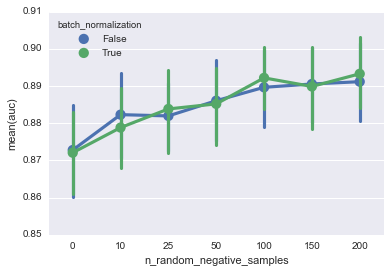

In [26]:
seaborn.pointplot(data=df, x="n_random_negative_samples", y="auc", hue="batch_normalization")

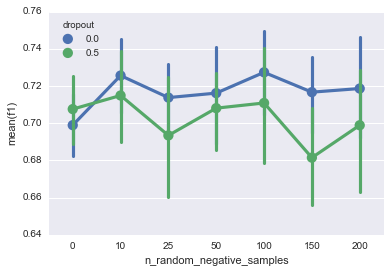

In [27]:
seaborn.pointplot(data=df, x="n_random_negative_samples", y="f1", hue="dropout")

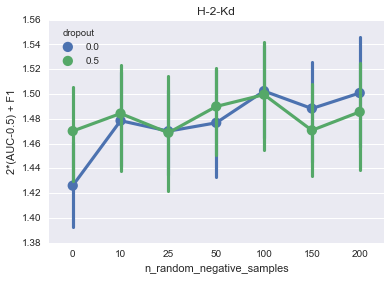

In [28]:
seaborn.pointplot(data=df, x="n_random_negative_samples", y=2*(df["auc"]-0.5) + df["f1"], hue="dropout")
seaborn.plt.ylabel("2*(AUC-0.5) + F1")
seaborn.plt.title("H-2-Kd")

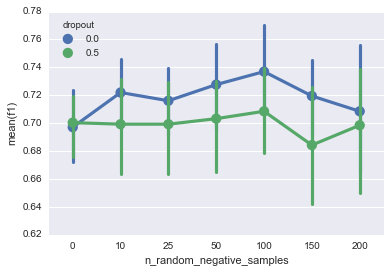

In [54]:
seaborn.pointplot(data=df[df.batch_normalization==False], x="n_random_negative_samples", y="f1", hue="dropout")

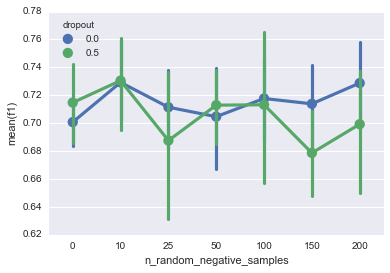

In [55]:
seaborn.pointplot(data=df[df.batch_normalization==True], x="n_random_negative_samples", y="f1", hue="dropout")

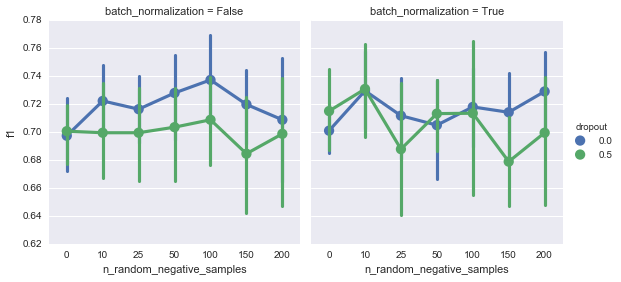

In [71]:
seaborn.factorplot(data=df,  x="n_random_negative_samples", y="f1", col="batch_normalization", hue="dropout", sharex=True)


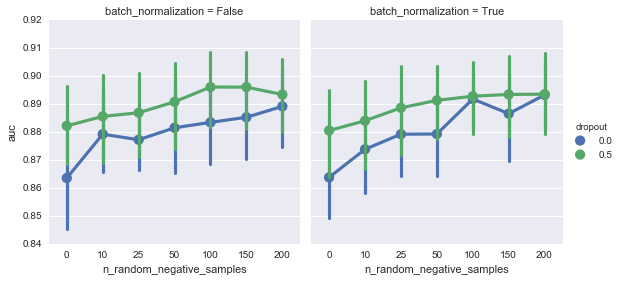

In [72]:
seaborn.factorplot(data=df,  x="n_random_negative_samples", y="auc", col="batch_normalization", hue="dropout", sharex=True)


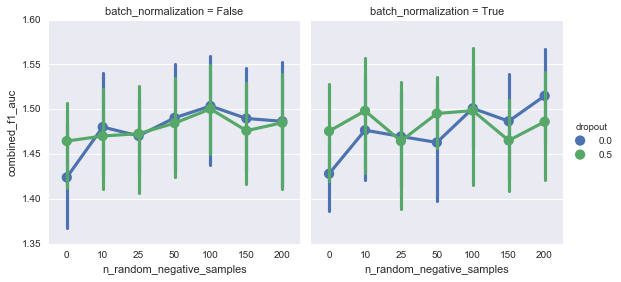

In [76]:
seaborn.factorplot(data=df,  x="n_random_negative_samples", y="combined_f1_auc", col="batch_normalization", hue="dropout", sharex=True)


In [67]:
"""

H-2-KD (5 repeats of 3-fold CV), 250 training epochs, batch_size=128, n_random_negative_samples=0, dropout=0.5, embedding_dim=32
Mean AUC without BN: 0.875584
Mean AUC with BN: 0.876215
Mean F1 without BN: 0.688881
Mean F1 with BN: 0.693462


H-2-KD (5 repeats of 3-fold CV), 250 training epochs, batch_size=32, n_random_negative_samples=0, dropout=0.5, embedding_dim=32
Mean AUC without BN: 0.880752
Mean AUC with BN: 0.881297
Mean F1 without BN: 0.701469
Mean F1 with BN: 0.701780

H-2-KD (5 repeats of 3-fold CV), 250 training epochs, batch_size=32, n_random_negative_samples=100, dropout=0.5, embedding_dim=32
Mean AUC without BN: 0.892155
Mean AUC with BN: 0.890272
Mean F1 without BN: 0.713683
Mean F1 with BN: 0.696640

H-2-KD (5 repeats of 3-fold CV), 250 training epochs, batch_size=32, n_random_negative_samples=0, dropout=0.5, embedding_dim=128
Mean AUC without BN: 0.878490
Mean AUC with BN: 0.880064
Mean F1 without BN: 0.702018
Mean F1 with BN: 0.680172

H-2-KD (5 repeats of 3-fold CV), 250 training epochs, batch_size=32, n_random_negative_samples=0, dropout=0.5, embedding_dim=32, imputation=none
Mean AUC without BN: 0.883124
Mean AUC with BN: 0.883220
Mean F1 without BN: 0.723242
Mean F1 with BN: 0.710092

H-2-KD (5 repeats of 3-fold CV), 250 training epochs, batch_size=32, n_random_negative_samples=0, dropout=0.25, embedding_dim=32, imputation=none
Mean AUC without BN: 0.878858
Mean AUC with BN: 0.883840
Mean F1 without BN: 0.732037
Mean F1 with BN: 0.726159

"""

'\n\nH-2-KD (5 repeats of 3-fold CV), 250 training epochs, batch_size=128, n_random_negative_samples=0, dropout=0.5, embedding_dim=32\nMean AUC without BN: 0.875584\nMean AUC with BN: 0.876215\nMean F1 without BN: 0.688881\nMean F1 with BN: 0.693462\n\n\nH-2-KD (5 repeats of 3-fold CV), 250 training epochs, batch_size=32, n_random_negative_samples=0, dropout=0.5, embedding_dim=32\nMean AUC without BN: 0.880752\nMean AUC with BN: 0.881297\nMean F1 without BN: 0.701469\nMean F1 with BN: 0.701780\n\nH-2-KD (5 repeats of 3-fold CV), 250 training epochs, batch_size=32, n_random_negative_samples=100, dropout=0.5, embedding_dim=32\nMean AUC without BN: 0.892155\nMean AUC with BN: 0.890272\nMean F1 without BN: 0.713683\nMean F1 with BN: 0.696640\n\nH-2-KD (5 repeats of 3-fold CV), 250 training epochs, batch_size=32, n_random_negative_samples=0, dropout=0.5, embedding_dim=128\nMean AUC without BN: 0.878490\nMean AUC with BN: 0.880064\nMean F1 without BN: 0.702018\nMean F1 with BN: 0.680172\n\nH

In [7]:
"""
H-2-KD (3-fold CV)
------
Mean AUC without BN: 0.882413
Mean AUC with BN: 0.879477
Mean F1 without BN: 0.724988
Mean F1 with BN: 0.665159

Mean AUC without BN: 0.874808
Mean AUC with BN: 0.877772
Mean F1 without BN: 0.684663
Mean F1 with BN: 0.679917

Mean AUC without BN: 0.880267
Mean AUC with BN: 0.881913
Mean F1 without BN: 0.733048
Mean F1 with BN: 0.676894

Mean AUC without BN: 0.875338
Mean AUC with BN: 0.881041
Mean F1 without BN: 0.685999
Mean F1 with BN: 0.717126

"""

"""
HLA-B0702
---------
Dropout = 0.5, default epochs 250
Mean AUC without BN: 0.944441
Mean AUC with BN: 0.943627
Mean F1 without BN: 0.535865
Mean F1 with BN: 0.490646

Mean AUC without BN: 0.944478
Mean AUC with BN: 0.944592
Mean F1 without BN: 0.505386
Mean F1 with BN: 0.588543

Mean AUC without BN: 0.944955 
Mean AUC with BN: 0.945639
Mean F1 without BN: 0.397787
Mean F1 with BN: 0.427407

Mean AUC without BN: 0.945984
Mean AUC with BN: 0.945175
Mean F1 without BN: 0.428959
Mean F1 with BN: 0.501382
"""


"""
HLA-A0201
---------
Dropout = 0.5, default epochs 250
Mean AUC without BN: 0.951470
Mean AUC with BN: 0.951329
Mean F1 without BN: 0.834310
Mean F1 with BN: 0.831982

Dropout = 0.5, default epochs 250 (repeat)
Mean AUC without BN: 0.946440
Mean AUC with BN: 0.946567
Mean F1 without BN: 0.818972
Mean F1 with BN: 0.824429

Dropout = 0, epochs = 100
Mean AUC without BN: 0.941071
Mean AUC with BN: 0.941932
Mean F1 without BN: 0.802992
Mean F1 with BN: 0.817939

Dropout = 0, epochs = 250
Mean AUC without BN: 0.911311
Mean AUC with BN: 0.915372
Mean F1 without BN: 0.758346
Mean F1 with BN: 0.769460
"""


'\nHLA-A0201\n---------\nDropout = 0.5, default epochs 250\nMean AUC without BN: 0.951470\nMean AUC with BN: 0.951329\nMean F1 without BN: 0.834310\nMean F1 with BN: 0.831982\n\nDropout = 0.5, default epochs 250 (repeat)\nMean AUC without BN: 0.946440\nMean AUC with BN: 0.946567\nMean F1 without BN: 0.818972\nMean F1 with BN: 0.824429\n\nDropout = 0, epochs = 100\nMean AUC without BN: 0.941071\nMean AUC with BN: 0.941932\nMean F1 without BN: 0.802992\nMean F1 with BN: 0.817939\n\nDropout = 0, epochs = 250\nMean AUC without BN: 0.911311\nMean AUC with BN: 0.915372\nMean F1 without BN: 0.758346\nMean F1 with BN: 0.769460\n'

In [ ]:
sum(data.get_allele("HLA-B0803").affinities <= 500)

In [ ]:
for i in [0, 0.001, 0.01, 0.1, 0.25, 0.5, 1,2,3]:
    print("2**%f = %f" % (i, 2.0 ** i))

In [ ]:
%matplotlib inline

In [ ]:
roots = np.arange(1,50, dtype=complex)

In [ ]:
roots

In [ ]:
y = (-0.5) ** (1.0/roots)

In [ ]:
import seaborn

In [ ]:
seaborn.plt.plot(roots,y)

In [ ]:
y

In [ ]:
from numpy import sqrt


In [ ]:
[1,2,4]

In [ ]:
for i in numpy.arange(1,7,0.5)

In [ ]:
type(_117)

In [ ]:
np.array(_117)

In [ ]:
type(_120)

In [ ]:
_117

In [ ]:
_120

In [ ]:
_120.prod()

In [ ]:
_120.sum()

In [ ]:
["heloo", 7]

In [ ]:
"yellow is an imaginary construct shared by everyone"

In [ ]:
_128.split(" ")

In [ ]:
type (_129)

In [ ]:
for word in _129:
    print (word)

In [ ]:
for word in reversed(_129):
    print (word)

In [ ]:
backwards= []

In [ ]:
for word in reversed(_129):
    backwards.append(word)

In [ ]:
print (backwards)

In [ ]:
for word in reversed(backwards):
    print (word)

In [ ]:
list(reversed(_128.split(" ")))

In [ ]:
" ".join("".join(reversed(word)) for word in _128.split(" "))